### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from detectron2.structures import BoxMode
import torchvision.transforms as transforms
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
ccls = []
for i in range(ord('a'), ord('z')+1):
    ccls.append(chr(i))
temp = [str(i) for i in range(10)]
temp.extend(ccls)
aclass = temp

## 資料集路徑整理


In [3]:
class img_dataSet(Dataset):
    def __init__(self,folder):
        self.folder = folder
        self.img_name = os.listdir(self.folder)
        pass
    
    def __getitem__(self,ind):
        self.ind = ind
        # img tensor
        self.img_path = os.path.join(self.folder,self.img_name[ind])
        
        image = Image.open(self.img_path)
        convert_tensor = transforms.ToTensor()
        img_tensor = convert_tensor(image)# transform(image)
        L = img_tensor.size()[1]
        W = img_tensor.size()[2]
        self.label_path = os.path.join('train_label',self.img_name[ind].split('.')[0])+'.txt'
        
        if os.path.isfile(self.label_path):
            # img label
            with open(self.label_path,'r') as file:
                info = file.read().splitlines()
            number = [i.split(' ')[0] for i in info]
            lables = [i.split(' ')[1:] for i in info]
            lables_float=[] 
            number_float=[]
            for row,num in zip(lables,number):
                temp = [ float(i) for i in row]
                temp = [(temp[0]-temp[2]/2)*W ,(temp[1]-temp[3]/2)*L ,(temp[0]+temp[2]/2)*W ,(temp[1]+temp[3]/2)*L]
                lables_float.append(temp)   
            label = lables_float
        else:
            label = []
            number=[]
        number = [int(i) for i in number]
        return label,img_tensor,self.img_path,number
    
    def __len__(self):
        return len(self.img_name)
    
    def show(self,ind,loc = None):
        image = self.__getitem__(ind)[1]
        img = transforms.ToPILImage()(image)
#         if loc != None:
#             ImageDraw.ImageDraw(img)
#             a.rectangle(((x1, y1),(x2, y2)), fill=None, outline='red', width=3) 
        img.show()
        pass

## 製作登入資料集檔案json

In [4]:
def get_datasetDict(folder_N):
    data = img_dataSet(folder = folder_N)
#     data = img_dataSet(folder = 'train_img')
    dataset_dicts = []
    for i in range(data.__len__()):
        filename = data.__getitem__(i)[2]
        size = data.__getitem__(1)[1].size()
        height, width = size[1],size[2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width

        objs = []
        for label,num in zip(data.__getitem__(i)[0],data.__getitem__(i)[-1]):
            ob = {
                "bbox": label,
                "bbox_mode": 0,#BoxMode.XYXY_ABS
                #"segmentation": [poly], To draw a line, along to ballon
                #you will need this for mask RCNN
                "category_id": num,
                "iscrowd": 0
            }
            objs.append(ob)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
DatasetCatalog.register('train_img',lambda data='train_img': get_datasetDict(folder_N = 'train_img'))
MetadataCatalog.get('train_img').set(thing_classes = aclass)
number_metadata = MetadataCatalog.get('train_img')

## 設定訓練參數

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu" #<-----
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('train_img',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.015
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 36  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/13 08:19:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/datascience/conda/pytorch1_9forgpuonpython3_7vyy/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/datascience/conda/pytorch1_9forgpuonpython3_7vyy/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/datascience/conda/pytorch1_9forgpuonpython3_7vyy/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = n

[04/13 08:19:15 d2.engine.train_loop]: Starting training from iteration 0
[04/13 08:19:18 d2.utils.events]:  eta: 0:08:38  iter: 19  total_loss: 4.180  loss_cls: 3.093  loss_box_reg: 0.930  loss_rpn_cls: 0.044  loss_rpn_loc: 0.033  time: 0.1749  data_time: 0.0099  lr: 0.000300  max_mem: 2340M
[04/13 08:19:22 d2.utils.events]:  eta: 0:08:34  iter: 39  total_loss: 2.168  loss_cls: 1.196  loss_box_reg: 0.923  loss_rpn_cls: 0.007  loss_rpn_loc: 0.024  time: 0.1730  data_time: 0.0056  lr: 0.000599  max_mem: 2340M
[04/13 08:19:25 d2.utils.events]:  eta: 0:08:30  iter: 59  total_loss: 2.034  loss_cls: 1.072  loss_box_reg: 0.939  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.1729  data_time: 0.0056  lr: 0.000899  max_mem: 2340M
[04/13 08:19:29 d2.utils.events]:  eta: 0:08:27  iter: 79  total_loss: 1.972  loss_cls: 1.041  loss_box_reg: 0.925  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  time: 0.1729  data_time: 0.0053  lr: 0.001199  max_mem: 2340M
[04/13 08:19:32 d2.utils.events]:  eta: 0:08:2

In [7]:
print('done')

done


In [8]:
DatasetCatalog.register('test_img',lambda data='test_img': get_datasetDict(folder_N = 'test_img'))
MetadataCatalog.get('test_img').set(thing_classes=aclass)

namespace(name='test_img',
          thing_classes=['0',
                         '1',
                         '2',
                         '3',
                         '4',
                         '5',
                         '6',
                         '7',
                         '8',
                         '9',
                         'a',
                         'b',
                         'c',
                         'd',
                         'e',
                         'f',
                         'g',
                         'h',
                         'i',
                         'j',
                         'k',
                         'l',
                         'm',
                         'n',
                         'o',
                         'p',
                         'q',
                         'r',
                         's',
                         't',
                         'u',
                         'v',
             

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("test_img", )
predictor = DefaultPredictor(cfg)

In [10]:
dataset_dicts2 = get_datasetDict("test_img")

In [11]:
dataset_dicts2[0]

{'file_name': 'test_img/4APD2.jpg',
 'image_id': 0,
 'height': 60,
 'width': 200,
 'annotations': []}

In [12]:
im = cv2.imread('train_img/06Q7Z.jpg')
outputs = predictor(im)

In [13]:
outputs["instances"].to("cpu")

Instances(num_instances=6, image_height=60, image_width=200, fields=[pred_boxes: Boxes(tensor([[  9.4171,  19.8757,  24.9766,  41.2545],
        [ 74.7881,   9.0472,  95.7809,  33.8235],
        [137.4861,  21.5275, 157.8061,  42.4520],
        [ 31.7445,  23.9626,  49.6166,  40.5144],
        [ 97.9016,  10.6356, 117.5240,  32.3486],
        [ 74.2729,   8.1446,  94.2951,  27.8091]])), scores: tensor([0.9912, 0.9859, 0.9820, 0.9795, 0.9600, 0.7825]), pred_classes: tensor([ 0, 26, 35,  6,  7, 24])])

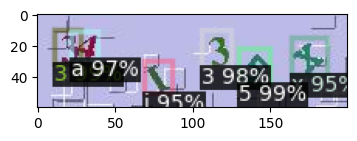

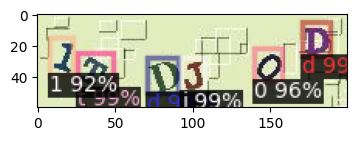

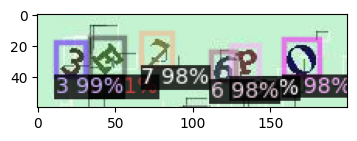

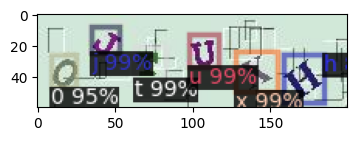

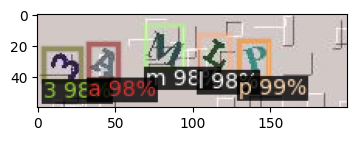

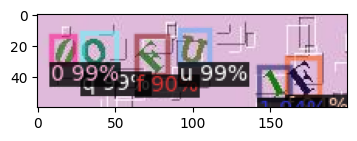

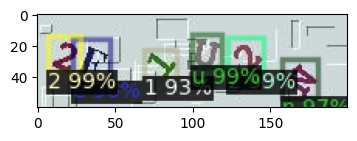

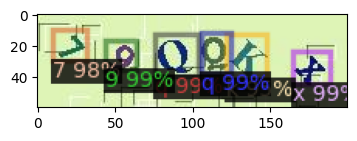

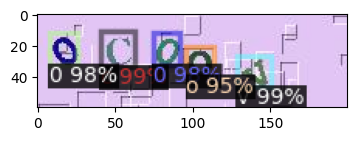

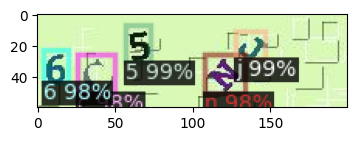

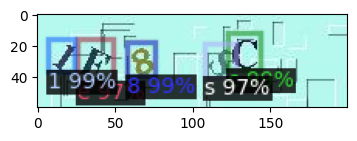

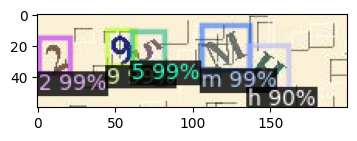

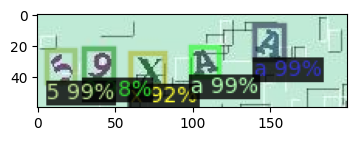

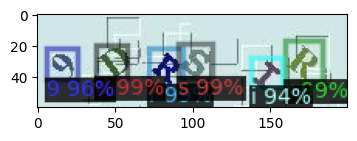

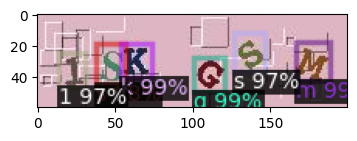

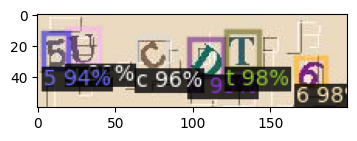

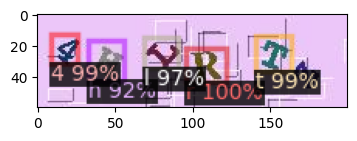

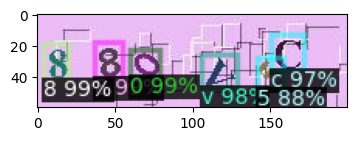

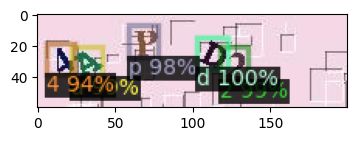

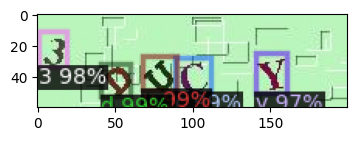

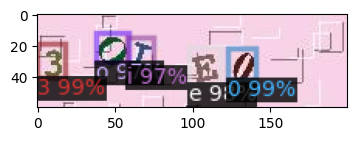

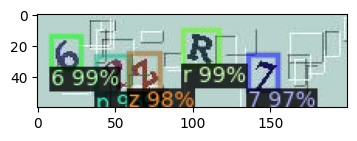

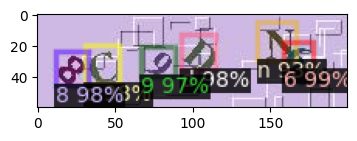

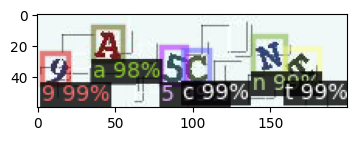

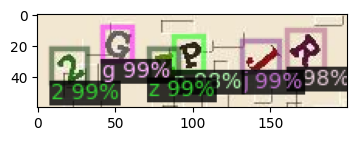

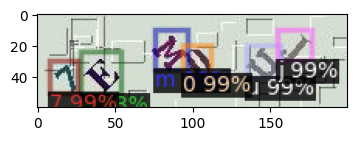

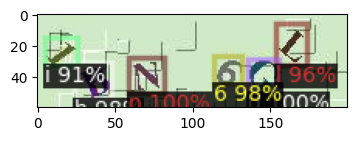

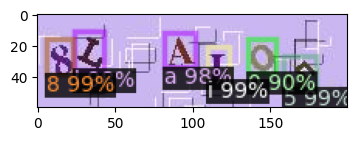

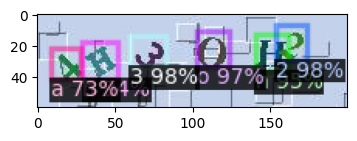

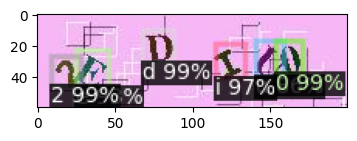

In [15]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = get_datasetDict("test_img")

for d in random.sample(dataset_dicts, 30):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=number_metadata, scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (4, 3))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [16]:
!pwd

/home/datascience/trainingTEST/practice_dataset
